In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import PIL.Image as pil_image
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import glob
import cv2
import random
import h5py
from skimage.measure import compare_ssim as ssim
import math
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/Final_Project/Images

/content/drive/My Drive/Final_Project/Images


In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1024)
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 16

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [0]:
path_91_x2_train_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91-image_x2.h5"
path_set5_x2_valid_samples_h5 = "/content/drive/My Drive/Final_Project/Images/Set_5/Set5_x2.h5"

path_91_x3_train_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91-image_x3.h5"
path_set5_x3_valid_samples_h5 = "/content/drive/My Drive/Final_Project/Images/Set_5/Set5_x3.h5"

path_91_x4_train_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91-image_x4.h5"
path_set5_x4_valid_samples_h5 = "/content/drive/My Drive/Final_Project/Images/Set_5/Set5_x4.h5"

In [0]:
# tf = h5py.File(path_91_x4_train_samples_h5, 'r')
# # df = h5py.File(deg_images_file, 'r') 
# h5_file = h5py.File('/content/drive/My Drive/Final_Project/Images/91_set/91_image_x4_valid', 'w')
# # degraded_images = np.array(tf['lr'][:])

In [0]:
# lr_patches = np.array(tf['hr'])[21000:]
# hr_patches = np.array(tf['lr'])[21000:]

In [0]:
# h5_file.create_dataset('lr', data=lr_patches)
# h5_file.create_dataset('hr', data=hr_patches)

<HDF5 dataset "hr": shape (772, 33, 33), type "<f4">

In [0]:
# h5_file.close()

In [0]:
class SubImagesTrainSet(Dataset):
    """Subimages dataset."""

    def __init__(self, images_path, scope = 'train'):
        images = h5py.File(images_path, 'r')
        self.true_images = np.array(images['hr'][:])
        self.deg_images = np.array(images['lr'][:])

    def __len__(self):
      return self.true_images.shape[0]
    
    def __getitem__(self, index):
      if torch.is_tensor(index):
            index = index.tolist()
      y = torch.tensor(self.true_images[index], dtype = torch.float, device = device)/255
      X = torch.tensor(self.deg_images[index], dtype = torch.float, device = device)/255
      return [torch.unsqueeze(X, dim = 2), torch.unsqueeze(y, dim = 2)]


In [0]:
class SubImagesValidSet(Dataset):
    """Subimages dataset."""

    def __init__(self, images_path, scope = 'train'):
        images = h5py.File(images_path, 'r')
        self.true_images = images['hr']
        self.deg_images = images['lr']

    def __len__(self):
      return len(self.true_images)
    
    def __getitem__(self, index):
      if torch.is_tensor(index):
            index = index.tolist()
      y = torch.tensor(np.array(self.true_images[str(index)][:]), dtype = torch.float, device = device)/255
      X = torch.tensor(np.array(self.deg_images[str(index)][:]), dtype = torch.float, device = device)/255
      return [torch.unsqueeze(X, dim = 2), torch.unsqueeze(y, dim = 2)]

In [0]:
train_dataset = SubImagesTrainSet(path_91_x2_train_samples_h5)

In [0]:
valid_dataset = SubImagesValidSet(path_set5_x2_valid_samples_h5)

In [0]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, *kwargs)

In [0]:
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = True, *kwargs)

In [0]:
def PSNR(target_image, ref_image):
  difference = torch.flatten((target_image.type(torch.float64) - ref_image.type(torch.float64)))
  mse = torch.mean(difference ** 2)
  return torch.mean(10 * torch.log10(1/mse))

In [0]:
class SRCNN(nn.Module):
  def __init__(self, num_filters_1, ker_size_1, num_filters_2, ker_size_2, ker_size_3):
    super(SRCNN, self).__init__()
    self.layer1_ = nn.Conv2d(1, num_filters_1, ker_size_1, padding=ker_size_1 // 2)
    self.layer2_ = nn.Conv2d(num_filters_1, num_filters_2, ker_size_2, padding=ker_size_2 // 2)
    self.layer3_ = nn.Conv2d(num_filters_2, 1, ker_size_3, padding=ker_size_3 // 2)
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self, X, transpose = True):
    if transpose:
      X = X.permute(0, 3, 1, 2)
    X = self.relu(self.layer1_(X))
    X = self.relu(self.layer2_(X))
    X = self.layer3_(X)
    if transpose:
      X = X.permute(0, 2, 3, 1)
    return X

In [0]:
num_fil_1 = 64
ker_1 = 9
num_fil_2 = 32
ker_2 = 3
ker_3 = 5

lr = 1e-4

Model = SRCNN(num_fil_1, ker_1, num_fil_2, ker_2, ker_3).to(device)

In [15]:
#architecture
print(Model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in Model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(Model):,} trainable parameters')

SRCNN(
  (layer1_): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (layer2_): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer3_): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)
The model has 24,513 trainable parameters


In [0]:
optimizer = optim.Adam([
                {'params': Model.layer1_.parameters()},
                {'params': Model.layer2_.parameters()},
                {'params': Model.layer3_.parameters(), 'lr': lr * 0.1}
            ], lr=lr)

criterion = torch.nn.MSELoss()

In [0]:
def train_model(model, train_iterator, optimizer, criterion, epoch):
  epoch_loss = 0
  epoch_PSNR = 0  
  #set the model in training phase
  model.train()  
  it = 0  
  with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size),leave = True, position=0) as t:
    t.set_description('epoch: {}/{}'.format(epoch, NUM_EPOCHS - 1))   

    for degraded_images, true_images in train_iterator:
      #resets the gradients after every batch
      optimizer.zero_grad()  
          
      #convert to 1D tensor
      predictied_images = model(degraded_images)
      #true_images = true_images[:, :predictied_images.shape[1], :predictied_images.shape[2], :]  
          
      #compute the loss
      loss = criterion(predictied_images, true_images)        
          
      #backpropage the loss and compute the gradients
      loss.backward()       
          
      #update the weights
      optimizer.step()  

      #compute the PSNR
      psnr = PSNR(predictied_images, true_images)       
          
      #loss and accuracy
      epoch_loss += loss.item()  
      epoch_PSNR += psnr.item()   
      it += 1

      t.set_postfix(loss='{:.6f}'.format(epoch_loss / it))
      t.update(len(true_images)) 
        
  return epoch_loss / len(train_iterator), epoch_PSNR / len(train_iterator)

In [0]:
def evaluate(model, valid_iterator, criterion):
    
  #initialize every epoch
  epoch_loss = 0
  epoch_PSNR = 0

  #deactivating dropout layers
  model.eval()
    
  #deactivates autograd
  with torch.no_grad():
    
    for degraded_images, true_images in valid_iterator:
            
      #convert to 1d tensor
      predictied_images = model(degraded_images).clamp(0.0, 1.0) 

      #compute loss and psnr
      loss = criterion(predictied_images, true_images)
      psnr = PSNR(predictied_images, true_images)
            
      #keep track of loss and psnr
      epoch_loss += loss.item()
      epoch_PSNR += psnr.item()
        
  return epoch_loss / len(valid_iterator), epoch_PSNR / len(valid_iterator)

In [0]:
def plot_loss(loss, label, color='blue'):
    plt.plot(loss, label=label, color=color)
    plt.legend()

In [0]:
NUM_EPOCHS = 300
best_valid_loss = float('inf')

train_losses = []
train_psnrs = []
valid_losses = []
valid_psnrs = []

for epoch in range(NUM_EPOCHS):
     
    #train the model
    train_loss, train_psnr = train_model(Model, train_loader, optimizer, criterion, epoch)
    
    #evaluate the model
    valid_loss, valid_psnr = evaluate(Model, valid_loader, criterion)
    
    train_losses.append(train_loss)
    train_psnrs.append(train_psnr)
    valid_losses.append(valid_loss)
    valid_psnrs.append(valid_psnr)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model.state_dict(), '/content/drive/My Drive/Final_Project/good/saved_weights_91.pt')
    
    print("Epoch: ", epoch)
    print(f'\tTrain Loss: {train_loss * 255:.3f} | Train Acc: {train_psnr:.2f} db')
    print(f'\t Val. Loss: {valid_loss * 255:.3f} |  Val. Acc: {valid_psnr:.2f} db')

# plot_loss(train_losses,'train_loss','red')
# plot_loss(train_psnr,'train_psnr', 'green')
# plot_loss(valid_losses,'valid_loss',)
# plot_loss(valid_psnr, 'valid_psnr', 'magenta')

epoch: 1/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  0
	Train Loss: 1.616 | Train Acc: 26.90 db
	 Val. Loss: 0.149 |  Val. Acc: 33.94 db



epoch: 2/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  1
	Train Loss: 0.232 | Train Acc: 30.71 db
	 Val. Loss: 0.124 |  Val. Acc: 34.70 db



epoch: 3/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  2
	Train Loss: 0.200 | Train Acc: 31.40 db
	 Val. Loss: 0.116 |  Val. Acc: 34.96 db



epoch: 4/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  3
	Train Loss: 0.189 | Train Acc: 31.65 db
	 Val. Loss: 0.112 |  Val. Acc: 35.08 db



epoch: 5/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  4
	Train Loss: 0.184 | Train Acc: 31.79 db
	 Val. Loss: 0.110 |  Val. Acc: 35.16 db



epoch: 6/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  5
	Train Loss: 0.181 | Train Acc: 31.86 db
	 Val. Loss: 0.108 |  Val. Acc: 35.23 db



epoch: 7/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  6
	Train Loss: 0.178 | Train Acc: 31.94 db
	 Val. Loss: 0.106 |  Val. Acc: 35.27 db



epoch: 8/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  7
	Train Loss: 0.176 | Train Acc: 31.99 db
	 Val. Loss: 0.104 |  Val. Acc: 35.31 db



epoch: 9/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  8
	Train Loss: 0.175 | Train Acc: 32.02 db
	 Val. Loss: 0.103 |  Val. Acc: 35.32 db



epoch: 10/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  9
	Train Loss: 0.173 | Train Acc: 32.07 db
	 Val. Loss: 0.101 |  Val. Acc: 35.41 db



epoch: 11/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  10
	Train Loss: 0.172 | Train Acc: 32.10 db
	 Val. Loss: 0.099 |  Val. Acc: 35.44 db



epoch: 12/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  11
	Train Loss: 0.171 | Train Acc: 32.13 db
	 Val. Loss: 0.098 |  Val. Acc: 35.43 db



epoch: 13/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  12
	Train Loss: 0.170 | Train Acc: 32.15 db
	 Val. Loss: 0.097 |  Val. Acc: 35.48 db



epoch: 14/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  13
	Train Loss: 0.169 | Train Acc: 32.20 db
	 Val. Loss: 0.095 |  Val. Acc: 35.52 db



epoch: 15/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  14
	Train Loss: 0.168 | Train Acc: 32.18 db
	 Val. Loss: 0.096 |  Val. Acc: 35.44 db



epoch: 16/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  15
	Train Loss: 0.167 | Train Acc: 32.25 db
	 Val. Loss: 0.093 |  Val. Acc: 35.58 db



epoch: 17/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  16
	Train Loss: 0.167 | Train Acc: 32.25 db
	 Val. Loss: 0.092 |  Val. Acc: 35.61 db



epoch: 18/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  17
	Train Loss: 0.166 | Train Acc: 32.29 db
	 Val. Loss: 0.091 |  Val. Acc: 35.64 db



epoch: 19/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  18
	Train Loss: 0.165 | Train Acc: 32.29 db
	 Val. Loss: 0.091 |  Val. Acc: 35.64 db



epoch: 20/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  19
	Train Loss: 0.165 | Train Acc: 32.31 db
	 Val. Loss: 0.090 |  Val. Acc: 35.68 db



epoch: 21/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  20
	Train Loss: 0.164 | Train Acc: 32.31 db
	 Val. Loss: 0.092 |  Val. Acc: 35.53 db



epoch: 22/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  21
	Train Loss: 0.164 | Train Acc: 32.34 db
	 Val. Loss: 0.089 |  Val. Acc: 35.69 db



epoch: 23/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  22
	Train Loss: 0.163 | Train Acc: 32.33 db
	 Val. Loss: 0.089 |  Val. Acc: 35.71 db



epoch: 24/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  23
	Train Loss: 0.163 | Train Acc: 32.34 db
	 Val. Loss: 0.088 |  Val. Acc: 35.74 db



epoch: 25/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  24
	Train Loss: 0.162 | Train Acc: 32.38 db
	 Val. Loss: 0.088 |  Val. Acc: 35.74 db



epoch: 26/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  25
	Train Loss: 0.162 | Train Acc: 32.37 db
	 Val. Loss: 0.087 |  Val. Acc: 35.77 db



epoch: 27/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  26
	Train Loss: 0.161 | Train Acc: 32.39 db
	 Val. Loss: 0.088 |  Val. Acc: 35.69 db



epoch: 28/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  27
	Train Loss: 0.161 | Train Acc: 32.41 db
	 Val. Loss: 0.087 |  Val. Acc: 35.79 db



epoch: 29/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  28
	Train Loss: 0.160 | Train Acc: 32.41 db
	 Val. Loss: 0.086 |  Val. Acc: 35.81 db



epoch: 30/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  29
	Train Loss: 0.160 | Train Acc: 32.43 db
	 Val. Loss: 0.086 |  Val. Acc: 35.80 db



epoch: 31/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  30
	Train Loss: 0.159 | Train Acc: 32.45 db
	 Val. Loss: 0.085 |  Val. Acc: 35.82 db



epoch: 32/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  31
	Train Loss: 0.159 | Train Acc: 32.47 db
	 Val. Loss: 0.085 |  Val. Acc: 35.85 db



epoch: 33/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  32
	Train Loss: 0.159 | Train Acc: 32.47 db
	 Val. Loss: 0.085 |  Val. Acc: 35.86 db



epoch: 34/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  33
	Train Loss: 0.158 | Train Acc: 32.46 db
	 Val. Loss: 0.085 |  Val. Acc: 35.85 db



epoch: 35/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  34
	Train Loss: 0.158 | Train Acc: 32.50 db
	 Val. Loss: 0.084 |  Val. Acc: 35.89 db



epoch: 36/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  35
	Train Loss: 0.158 | Train Acc: 32.49 db
	 Val. Loss: 0.084 |  Val. Acc: 35.89 db



epoch: 37/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  36
	Train Loss: 0.157 | Train Acc: 32.52 db
	 Val. Loss: 0.084 |  Val. Acc: 35.85 db



epoch: 38/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  37
	Train Loss: 0.157 | Train Acc: 32.54 db
	 Val. Loss: 0.083 |  Val. Acc: 35.92 db



epoch: 39/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  38
	Train Loss: 0.157 | Train Acc: 32.52 db
	 Val. Loss: 0.083 |  Val. Acc: 35.90 db



epoch: 40/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  39
	Train Loss: 0.156 | Train Acc: 32.55 db
	 Val. Loss: 0.082 |  Val. Acc: 35.92 db



epoch: 41/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  40
	Train Loss: 0.156 | Train Acc: 32.55 db
	 Val. Loss: 0.082 |  Val. Acc: 35.94 db



epoch: 42/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  41
	Train Loss: 0.156 | Train Acc: 32.56 db
	 Val. Loss: 0.082 |  Val. Acc: 35.95 db



epoch: 43/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  42
	Train Loss: 0.155 | Train Acc: 32.55 db
	 Val. Loss: 0.082 |  Val. Acc: 35.95 db



epoch: 44/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  43
	Train Loss: 0.155 | Train Acc: 32.56 db
	 Val. Loss: 0.082 |  Val. Acc: 35.94 db



epoch: 45/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  44
	Train Loss: 0.155 | Train Acc: 32.56 db
	 Val. Loss: 0.081 |  Val. Acc: 36.00 db



epoch: 46/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  45
	Train Loss: 0.155 | Train Acc: 32.57 db
	 Val. Loss: 0.081 |  Val. Acc: 35.99 db



epoch: 47/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  46
	Train Loss: 0.154 | Train Acc: 32.61 db
	 Val. Loss: 0.080 |  Val. Acc: 36.01 db



epoch: 48/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  47
	Train Loss: 0.154 | Train Acc: 32.60 db
	 Val. Loss: 0.080 |  Val. Acc: 36.02 db



epoch: 49/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  48
	Train Loss: 0.154 | Train Acc: 32.59 db
	 Val. Loss: 0.080 |  Val. Acc: 36.01 db



epoch: 50/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  49
	Train Loss: 0.154 | Train Acc: 32.63 db
	 Val. Loss: 0.080 |  Val. Acc: 36.01 db



epoch: 51/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  50
	Train Loss: 0.153 | Train Acc: 32.63 db
	 Val. Loss: 0.080 |  Val. Acc: 36.04 db



epoch: 52/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  51
	Train Loss: 0.153 | Train Acc: 32.61 db
	 Val. Loss: 0.080 |  Val. Acc: 36.03 db



epoch: 53/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  52
	Train Loss: 0.153 | Train Acc: 32.62 db
	 Val. Loss: 0.080 |  Val. Acc: 36.03 db



epoch: 54/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  53
	Train Loss: 0.153 | Train Acc: 32.66 db
	 Val. Loss: 0.080 |  Val. Acc: 36.06 db



epoch: 55/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  54
	Train Loss: 0.153 | Train Acc: 32.64 db
	 Val. Loss: 0.079 |  Val. Acc: 36.07 db



epoch: 56/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  55
	Train Loss: 0.152 | Train Acc: 32.67 db
	 Val. Loss: 0.079 |  Val. Acc: 36.07 db



epoch: 57/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  56
	Train Loss: 0.152 | Train Acc: 32.63 db
	 Val. Loss: 0.080 |  Val. Acc: 36.01 db



epoch: 58/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  57
	Train Loss: 0.152 | Train Acc: 32.66 db
	 Val. Loss: 0.079 |  Val. Acc: 36.06 db



epoch: 59/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  58
	Train Loss: 0.152 | Train Acc: 32.68 db
	 Val. Loss: 0.079 |  Val. Acc: 36.08 db



epoch: 60/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  59
	Train Loss: 0.152 | Train Acc: 32.68 db
	 Val. Loss: 0.079 |  Val. Acc: 36.09 db



epoch: 61/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  60
	Train Loss: 0.152 | Train Acc: 32.67 db
	 Val. Loss: 0.078 |  Val. Acc: 36.11 db



epoch: 62/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  61
	Train Loss: 0.151 | Train Acc: 32.69 db
	 Val. Loss: 0.078 |  Val. Acc: 36.11 db



epoch: 63/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  62
	Train Loss: 0.151 | Train Acc: 32.69 db
	 Val. Loss: 0.079 |  Val. Acc: 36.05 db



epoch: 64/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  63
	Train Loss: 0.151 | Train Acc: 32.69 db
	 Val. Loss: 0.078 |  Val. Acc: 36.09 db



epoch: 65/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  64
	Train Loss: 0.151 | Train Acc: 32.71 db
	 Val. Loss: 0.078 |  Val. Acc: 36.10 db



epoch: 66/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  65
	Train Loss: 0.151 | Train Acc: 32.71 db
	 Val. Loss: 0.078 |  Val. Acc: 36.11 db



epoch: 67/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  66
	Train Loss: 0.151 | Train Acc: 32.70 db
	 Val. Loss: 0.078 |  Val. Acc: 36.06 db



epoch: 68/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  67
	Train Loss: 0.151 | Train Acc: 32.72 db
	 Val. Loss: 0.078 |  Val. Acc: 36.07 db



epoch: 69/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  68
	Train Loss: 0.150 | Train Acc: 32.73 db
	 Val. Loss: 0.078 |  Val. Acc: 36.12 db



epoch: 70/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  69
	Train Loss: 0.150 | Train Acc: 32.72 db
	 Val. Loss: 0.078 |  Val. Acc: 36.12 db



epoch: 71/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  70
	Train Loss: 0.150 | Train Acc: 32.71 db
	 Val. Loss: 0.077 |  Val. Acc: 36.13 db



epoch: 72/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  71
	Train Loss: 0.150 | Train Acc: 32.72 db
	 Val. Loss: 0.078 |  Val. Acc: 36.13 db



epoch: 73/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  72
	Train Loss: 0.150 | Train Acc: 32.72 db
	 Val. Loss: 0.077 |  Val. Acc: 36.17 db



epoch: 74/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  73
	Train Loss: 0.150 | Train Acc: 32.73 db
	 Val. Loss: 0.077 |  Val. Acc: 36.14 db



epoch: 75/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  74
	Train Loss: 0.149 | Train Acc: 32.77 db
	 Val. Loss: 0.077 |  Val. Acc: 36.16 db



epoch: 76/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  75
	Train Loss: 0.149 | Train Acc: 32.74 db
	 Val. Loss: 0.077 |  Val. Acc: 36.16 db



epoch: 77/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  76
	Train Loss: 0.149 | Train Acc: 32.74 db
	 Val. Loss: 0.078 |  Val. Acc: 36.07 db



epoch: 78/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  77
	Train Loss: 0.149 | Train Acc: 32.76 db
	 Val. Loss: 0.076 |  Val. Acc: 36.19 db



epoch: 79/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  78
	Train Loss: 0.149 | Train Acc: 32.77 db
	 Val. Loss: 0.077 |  Val. Acc: 36.15 db



epoch: 80/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  79
	Train Loss: 0.149 | Train Acc: 32.77 db
	 Val. Loss: 0.077 |  Val. Acc: 36.18 db



epoch: 81/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  80
	Train Loss: 0.149 | Train Acc: 32.74 db
	 Val. Loss: 0.076 |  Val. Acc: 36.19 db



epoch: 82/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  81
	Train Loss: 0.148 | Train Acc: 32.81 db
	 Val. Loss: 0.076 |  Val. Acc: 36.18 db



epoch: 83/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  82
	Train Loss: 0.148 | Train Acc: 32.79 db
	 Val. Loss: 0.076 |  Val. Acc: 36.20 db



epoch: 84/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  83
	Train Loss: 0.148 | Train Acc: 32.77 db
	 Val. Loss: 0.077 |  Val. Acc: 36.15 db



epoch: 85/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  84
	Train Loss: 0.148 | Train Acc: 32.78 db
	 Val. Loss: 0.077 |  Val. Acc: 36.16 db



epoch: 86/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  85
	Train Loss: 0.148 | Train Acc: 32.79 db
	 Val. Loss: 0.076 |  Val. Acc: 36.21 db



epoch: 87/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  86
	Train Loss: 0.148 | Train Acc: 32.80 db
	 Val. Loss: 0.076 |  Val. Acc: 36.19 db



epoch: 88/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  87
	Train Loss: 0.148 | Train Acc: 32.77 db
	 Val. Loss: 0.076 |  Val. Acc: 36.20 db



epoch: 89/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  88
	Train Loss: 0.148 | Train Acc: 32.79 db
	 Val. Loss: 0.076 |  Val. Acc: 36.23 db



epoch: 90/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  89
	Train Loss: 0.148 | Train Acc: 32.80 db
	 Val. Loss: 0.075 |  Val. Acc: 36.24 db



epoch: 91/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  90
	Train Loss: 0.148 | Train Acc: 32.78 db
	 Val. Loss: 0.076 |  Val. Acc: 36.22 db



epoch: 92/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  91
	Train Loss: 0.147 | Train Acc: 32.82 db
	 Val. Loss: 0.076 |  Val. Acc: 36.21 db



epoch: 93/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  92
	Train Loss: 0.147 | Train Acc: 32.82 db
	 Val. Loss: 0.076 |  Val. Acc: 36.16 db



epoch: 94/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  93
	Train Loss: 0.147 | Train Acc: 32.81 db
	 Val. Loss: 0.075 |  Val. Acc: 36.25 db



epoch: 95/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  94
	Train Loss: 0.147 | Train Acc: 32.81 db
	 Val. Loss: 0.081 |  Val. Acc: 35.82 db



epoch: 96/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  95
	Train Loss: 0.147 | Train Acc: 32.80 db
	 Val. Loss: 0.075 |  Val. Acc: 36.25 db



epoch: 97/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  96
	Train Loss: 0.147 | Train Acc: 32.84 db
	 Val. Loss: 0.075 |  Val. Acc: 36.24 db



epoch: 98/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  97
	Train Loss: 0.147 | Train Acc: 32.84 db
	 Val. Loss: 0.075 |  Val. Acc: 36.25 db



epoch: 99/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  98
	Train Loss: 0.147 | Train Acc: 32.81 db
	 Val. Loss: 0.075 |  Val. Acc: 36.23 db



epoch: 100/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  99
	Train Loss: 0.147 | Train Acc: 32.84 db
	 Val. Loss: 0.075 |  Val. Acc: 36.24 db



epoch: 101/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  100
	Train Loss: 0.147 | Train Acc: 32.83 db
	 Val. Loss: 0.075 |  Val. Acc: 36.24 db



epoch: 102/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  101
	Train Loss: 0.146 | Train Acc: 32.83 db
	 Val. Loss: 0.075 |  Val. Acc: 36.21 db



epoch: 103/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  102
	Train Loss: 0.146 | Train Acc: 32.84 db
	 Val. Loss: 0.075 |  Val. Acc: 36.25 db



epoch: 104/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  103
	Train Loss: 0.146 | Train Acc: 32.83 db
	 Val. Loss: 0.075 |  Val. Acc: 36.27 db



epoch: 105/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  104
	Train Loss: 0.146 | Train Acc: 32.86 db
	 Val. Loss: 0.075 |  Val. Acc: 36.25 db



epoch: 106/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  105
	Train Loss: 0.146 | Train Acc: 32.85 db
	 Val. Loss: 0.074 |  Val. Acc: 36.29 db



epoch: 107/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  106
	Train Loss: 0.146 | Train Acc: 32.83 db
	 Val. Loss: 0.075 |  Val. Acc: 36.24 db



epoch: 108/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  107
	Train Loss: 0.146 | Train Acc: 32.85 db
	 Val. Loss: 0.075 |  Val. Acc: 36.28 db



epoch: 109/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  108
	Train Loss: 0.146 | Train Acc: 32.86 db
	 Val. Loss: 0.075 |  Val. Acc: 36.27 db



epoch: 110/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  109
	Train Loss: 0.146 | Train Acc: 32.85 db
	 Val. Loss: 0.075 |  Val. Acc: 36.26 db



epoch: 111/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  110
	Train Loss: 0.146 | Train Acc: 32.87 db
	 Val. Loss: 0.074 |  Val. Acc: 36.28 db



epoch: 112/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  111
	Train Loss: 0.146 | Train Acc: 32.89 db
	 Val. Loss: 0.075 |  Val. Acc: 36.27 db



epoch: 113/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  112
	Train Loss: 0.146 | Train Acc: 32.86 db
	 Val. Loss: 0.075 |  Val. Acc: 36.24 db



epoch: 114/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  113
	Train Loss: 0.146 | Train Acc: 32.88 db
	 Val. Loss: 0.075 |  Val. Acc: 36.27 db



epoch: 115/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  114
	Train Loss: 0.145 | Train Acc: 32.87 db
	 Val. Loss: 0.074 |  Val. Acc: 36.29 db



epoch: 116/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  115
	Train Loss: 0.145 | Train Acc: 32.90 db
	 Val. Loss: 0.074 |  Val. Acc: 36.31 db



epoch: 117/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  116
	Train Loss: 0.145 | Train Acc: 32.88 db
	 Val. Loss: 0.074 |  Val. Acc: 36.29 db



epoch: 118/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  117
	Train Loss: 0.145 | Train Acc: 32.86 db
	 Val. Loss: 0.074 |  Val. Acc: 36.27 db



epoch: 119/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  118
	Train Loss: 0.145 | Train Acc: 32.87 db
	 Val. Loss: 0.074 |  Val. Acc: 36.26 db



epoch: 120/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  119
	Train Loss: 0.145 | Train Acc: 32.87 db
	 Val. Loss: 0.074 |  Val. Acc: 36.29 db



epoch: 121/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  120
	Train Loss: 0.145 | Train Acc: 32.89 db
	 Val. Loss: 0.074 |  Val. Acc: 36.31 db



epoch: 122/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  121
	Train Loss: 0.145 | Train Acc: 32.87 db
	 Val. Loss: 0.074 |  Val. Acc: 36.30 db



epoch: 123/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  122
	Train Loss: 0.145 | Train Acc: 32.88 db
	 Val. Loss: 0.074 |  Val. Acc: 36.30 db



epoch: 124/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  123
	Train Loss: 0.145 | Train Acc: 32.89 db
	 Val. Loss: 0.074 |  Val. Acc: 36.26 db



epoch: 125/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  124
	Train Loss: 0.145 | Train Acc: 32.88 db
	 Val. Loss: 0.074 |  Val. Acc: 36.33 db



epoch: 126/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  125
	Train Loss: 0.145 | Train Acc: 32.90 db
	 Val. Loss: 0.074 |  Val. Acc: 36.28 db



epoch: 127/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  126
	Train Loss: 0.145 | Train Acc: 32.86 db
	 Val. Loss: 0.074 |  Val. Acc: 36.32 db



epoch: 128/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  127
	Train Loss: 0.145 | Train Acc: 32.87 db
	 Val. Loss: 0.074 |  Val. Acc: 36.31 db



epoch: 129/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  128
	Train Loss: 0.144 | Train Acc: 32.89 db
	 Val. Loss: 0.074 |  Val. Acc: 36.30 db



epoch: 130/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  129
	Train Loss: 0.145 | Train Acc: 32.88 db
	 Val. Loss: 0.074 |  Val. Acc: 36.30 db



epoch: 131/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  130
	Train Loss: 0.144 | Train Acc: 32.91 db
	 Val. Loss: 0.074 |  Val. Acc: 36.27 db



epoch: 132/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  131
	Train Loss: 0.144 | Train Acc: 32.89 db
	 Val. Loss: 0.074 |  Val. Acc: 36.30 db



epoch: 133/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  132
	Train Loss: 0.144 | Train Acc: 32.88 db
	 Val. Loss: 0.074 |  Val. Acc: 36.31 db



epoch: 134/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  133
	Train Loss: 0.144 | Train Acc: 32.89 db
	 Val. Loss: 0.074 |  Val. Acc: 36.33 db



epoch: 135/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  134
	Train Loss: 0.144 | Train Acc: 32.88 db
	 Val. Loss: 0.073 |  Val. Acc: 36.32 db



epoch: 136/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  135
	Train Loss: 0.144 | Train Acc: 32.93 db
	 Val. Loss: 0.074 |  Val. Acc: 36.29 db



epoch: 137/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  136
	Train Loss: 0.144 | Train Acc: 32.89 db
	 Val. Loss: 0.074 |  Val. Acc: 36.30 db



epoch: 138/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  137
	Train Loss: 0.144 | Train Acc: 32.90 db
	 Val. Loss: 0.074 |  Val. Acc: 36.31 db



epoch: 139/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  138
	Train Loss: 0.144 | Train Acc: 32.92 db
	 Val. Loss: 0.074 |  Val. Acc: 36.32 db



epoch: 140/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  139
	Train Loss: 0.144 | Train Acc: 32.92 db
	 Val. Loss: 0.074 |  Val. Acc: 36.33 db



epoch: 141/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  140
	Train Loss: 0.144 | Train Acc: 32.91 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 142/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  141
	Train Loss: 0.144 | Train Acc: 32.92 db
	 Val. Loss: 0.074 |  Val. Acc: 36.28 db



epoch: 143/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  142
	Train Loss: 0.144 | Train Acc: 32.91 db
	 Val. Loss: 0.074 |  Val. Acc: 36.28 db



epoch: 144/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  143
	Train Loss: 0.144 | Train Acc: 32.91 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 145/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  144
	Train Loss: 0.144 | Train Acc: 32.90 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 146/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  145
	Train Loss: 0.144 | Train Acc: 32.92 db
	 Val. Loss: 0.074 |  Val. Acc: 36.27 db



epoch: 147/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  146
	Train Loss: 0.144 | Train Acc: 32.90 db
	 Val. Loss: 0.074 |  Val. Acc: 36.32 db



epoch: 148/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  147
	Train Loss: 0.143 | Train Acc: 32.94 db
	 Val. Loss: 0.073 |  Val. Acc: 36.35 db



epoch: 149/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  148
	Train Loss: 0.144 | Train Acc: 32.92 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 150/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  149
	Train Loss: 0.143 | Train Acc: 32.92 db
	 Val. Loss: 0.073 |  Val. Acc: 36.33 db



epoch: 151/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  150
	Train Loss: 0.143 | Train Acc: 32.94 db
	 Val. Loss: 0.074 |  Val. Acc: 36.30 db



epoch: 152/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  151
	Train Loss: 0.143 | Train Acc: 32.93 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 153/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  152
	Train Loss: 0.143 | Train Acc: 32.93 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 154/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  153
	Train Loss: 0.143 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 155/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  154
	Train Loss: 0.143 | Train Acc: 32.94 db
	 Val. Loss: 0.074 |  Val. Acc: 36.33 db



epoch: 156/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  155
	Train Loss: 0.143 | Train Acc: 32.94 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 157/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  156
	Train Loss: 0.143 | Train Acc: 32.92 db
	 Val. Loss: 0.073 |  Val. Acc: 36.35 db



epoch: 158/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  157
	Train Loss: 0.143 | Train Acc: 32.92 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 159/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  158
	Train Loss: 0.143 | Train Acc: 32.96 db
	 Val. Loss: 0.073 |  Val. Acc: 36.31 db



epoch: 160/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  159
	Train Loss: 0.143 | Train Acc: 32.96 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 161/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  160
	Train Loss: 0.143 | Train Acc: 32.93 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 162/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  161
	Train Loss: 0.143 | Train Acc: 32.94 db
	 Val. Loss: 0.073 |  Val. Acc: 36.33 db



epoch: 163/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  162
	Train Loss: 0.143 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 164/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  163
	Train Loss: 0.143 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 165/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  164
	Train Loss: 0.143 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.33 db



epoch: 166/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  165
	Train Loss: 0.143 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 167/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  166
	Train Loss: 0.143 | Train Acc: 32.93 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 168/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  167
	Train Loss: 0.143 | Train Acc: 32.96 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 169/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  168
	Train Loss: 0.143 | Train Acc: 32.94 db
	 Val. Loss: 0.073 |  Val. Acc: 36.37 db



epoch: 170/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  169
	Train Loss: 0.143 | Train Acc: 32.97 db
	 Val. Loss: 0.073 |  Val. Acc: 36.37 db



epoch: 171/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  170
	Train Loss: 0.143 | Train Acc: 32.96 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 172/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  171
	Train Loss: 0.142 | Train Acc: 32.96 db
	 Val. Loss: 0.073 |  Val. Acc: 36.35 db



epoch: 173/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  172
	Train Loss: 0.142 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.33 db



epoch: 174/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  173
	Train Loss: 0.142 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.33 db



epoch: 175/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  174
	Train Loss: 0.142 | Train Acc: 32.96 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 176/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  175
	Train Loss: 0.142 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 177/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  176
	Train Loss: 0.142 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.37 db



epoch: 178/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  177
	Train Loss: 0.142 | Train Acc: 32.95 db
	 Val. Loss: 0.073 |  Val. Acc: 36.33 db



epoch: 179/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  178
	Train Loss: 0.142 | Train Acc: 32.96 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 180/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  179
	Train Loss: 0.142 | Train Acc: 32.97 db
	 Val. Loss: 0.072 |  Val. Acc: 36.38 db



epoch: 181/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  180
	Train Loss: 0.142 | Train Acc: 32.97 db
	 Val. Loss: 0.073 |  Val. Acc: 36.38 db



epoch: 182/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  181
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.073 |  Val. Acc: 36.37 db



epoch: 183/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  182
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.072 |  Val. Acc: 36.38 db



epoch: 184/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  183
	Train Loss: 0.142 | Train Acc: 32.96 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 185/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  184
	Train Loss: 0.142 | Train Acc: 32.97 db
	 Val. Loss: 0.073 |  Val. Acc: 36.37 db



epoch: 186/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  185
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.073 |  Val. Acc: 36.37 db



epoch: 187/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  186
	Train Loss: 0.142 | Train Acc: 32.96 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 188/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  187
	Train Loss: 0.142 | Train Acc: 32.98 db
	 Val. Loss: 0.073 |  Val. Acc: 36.38 db



epoch: 189/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  188
	Train Loss: 0.142 | Train Acc: 33.00 db
	 Val. Loss: 0.073 |  Val. Acc: 36.37 db



epoch: 190/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  189
	Train Loss: 0.142 | Train Acc: 33.00 db
	 Val. Loss: 0.073 |  Val. Acc: 36.38 db



epoch: 191/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  190
	Train Loss: 0.142 | Train Acc: 32.96 db
	 Val. Loss: 0.073 |  Val. Acc: 36.38 db



epoch: 192/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  191
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.072 |  Val. Acc: 36.38 db



epoch: 193/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  192
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.073 |  Val. Acc: 36.39 db



epoch: 194/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  193
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 195/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  194
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 196/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  195
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 197/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  196
	Train Loss: 0.142 | Train Acc: 32.97 db
	 Val. Loss: 0.072 |  Val. Acc: 36.38 db



epoch: 198/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  197
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.072 |  Val. Acc: 36.40 db



epoch: 199/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  198
	Train Loss: 0.142 | Train Acc: 32.99 db
	 Val. Loss: 0.072 |  Val. Acc: 36.38 db



epoch: 200/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  199
	Train Loss: 0.142 | Train Acc: 32.98 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 201/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  200
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 202/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  201
	Train Loss: 0.141 | Train Acc: 32.99 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 203/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  202
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.073 |  Val. Acc: 36.37 db



epoch: 204/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  203
	Train Loss: 0.141 | Train Acc: 32.99 db
	 Val. Loss: 0.073 |  Val. Acc: 36.32 db



epoch: 205/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  204
	Train Loss: 0.141 | Train Acc: 33.01 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 206/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  205
	Train Loss: 0.141 | Train Acc: 33.02 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 207/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  206
	Train Loss: 0.141 | Train Acc: 32.98 db
	 Val. Loss: 0.072 |  Val. Acc: 36.36 db



epoch: 208/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  207
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 209/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  208
	Train Loss: 0.141 | Train Acc: 32.97 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 210/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  209
	Train Loss: 0.141 | Train Acc: 32.98 db
	 Val. Loss: 0.073 |  Val. Acc: 36.35 db



epoch: 211/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  210
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 212/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  211
	Train Loss: 0.141 | Train Acc: 32.97 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 213/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  212
	Train Loss: 0.141 | Train Acc: 33.01 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 214/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  213
	Train Loss: 0.141 | Train Acc: 32.99 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 215/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  214
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 216/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  215
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.40 db



epoch: 217/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  216
	Train Loss: 0.141 | Train Acc: 33.02 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 218/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  217
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 219/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  218
	Train Loss: 0.141 | Train Acc: 32.99 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 220/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  219
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 221/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  220
	Train Loss: 0.141 | Train Acc: 33.01 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 222/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  221
	Train Loss: 0.141 | Train Acc: 33.02 db
	 Val. Loss: 0.072 |  Val. Acc: 36.37 db



epoch: 223/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  222
	Train Loss: 0.141 | Train Acc: 33.02 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 224/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  223
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 225/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  224
	Train Loss: 0.141 | Train Acc: 33.04 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 226/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  225
	Train Loss: 0.141 | Train Acc: 33.01 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 227/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  226
	Train Loss: 0.141 | Train Acc: 33.01 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 228/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  227
	Train Loss: 0.141 | Train Acc: 33.02 db
	 Val. Loss: 0.073 |  Val. Acc: 36.29 db



epoch: 229/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  228
	Train Loss: 0.141 | Train Acc: 33.02 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 230/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  229
	Train Loss: 0.141 | Train Acc: 33.03 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 231/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  230
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 232/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  231
	Train Loss: 0.141 | Train Acc: 33.02 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 233/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  232
	Train Loss: 0.141 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 234/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  233
	Train Loss: 0.141 | Train Acc: 33.02 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 235/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  234
	Train Loss: 0.141 | Train Acc: 33.02 db
	 Val. Loss: 0.071 |  Val. Acc: 36.43 db



epoch: 236/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  235
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 237/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  236
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.072 |  Val. Acc: 36.40 db



epoch: 238/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  237
	Train Loss: 0.140 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 239/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  238
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 240/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  239
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 241/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  240
	Train Loss: 0.140 | Train Acc: 33.02 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 242/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  241
	Train Loss: 0.140 | Train Acc: 33.01 db
	 Val. Loss: 0.072 |  Val. Acc: 36.40 db



epoch: 243/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  242
	Train Loss: 0.140 | Train Acc: 33.00 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 244/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  243
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.43 db



epoch: 245/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  244
	Train Loss: 0.140 | Train Acc: 33.05 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 246/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  245
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.073 |  Val. Acc: 36.36 db



epoch: 247/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  246
	Train Loss: 0.140 | Train Acc: 33.02 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 248/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  247
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 249/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  248
	Train Loss: 0.140 | Train Acc: 33.02 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 250/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  249
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.43 db



epoch: 251/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  250
	Train Loss: 0.140 | Train Acc: 33.01 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 252/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  251
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.072 |  Val. Acc: 36.40 db



epoch: 253/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  252
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 254/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  253
	Train Loss: 0.140 | Train Acc: 33.01 db
	 Val. Loss: 0.072 |  Val. Acc: 36.40 db



epoch: 255/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  254
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.072 |  Val. Acc: 36.40 db



epoch: 256/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  255
	Train Loss: 0.140 | Train Acc: 33.05 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db



epoch: 257/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  256
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 258/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  257
	Train Loss: 0.140 | Train Acc: 33.07 db
	 Val. Loss: 0.071 |  Val. Acc: 36.43 db



epoch: 259/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  258
	Train Loss: 0.140 | Train Acc: 33.05 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db



epoch: 260/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  259
	Train Loss: 0.140 | Train Acc: 33.05 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 261/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  260
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 262/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  261
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 263/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  262
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.42 db



epoch: 264/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  263
	Train Loss: 0.140 | Train Acc: 33.08 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 265/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  264
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db



epoch: 266/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  265
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 267/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  266
	Train Loss: 0.140 | Train Acc: 33.05 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 268/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  267
	Train Loss: 0.140 | Train Acc: 33.05 db
	 Val. Loss: 0.072 |  Val. Acc: 36.43 db



epoch: 269/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  268
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 270/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  269
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 271/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  270
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 272/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  271
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 273/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  272
	Train Loss: 0.140 | Train Acc: 33.06 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 274/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  273
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.42 db



epoch: 275/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  274
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db



epoch: 276/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  275
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 277/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  276
	Train Loss: 0.140 | Train Acc: 33.08 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 278/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  277
	Train Loss: 0.140 | Train Acc: 33.05 db
	 Val. Loss: 0.073 |  Val. Acc: 36.34 db



epoch: 279/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  278
	Train Loss: 0.140 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.43 db



epoch: 280/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  279
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.43 db



epoch: 281/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  280
	Train Loss: 0.140 | Train Acc: 33.06 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 282/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  281
	Train Loss: 0.140 | Train Acc: 33.06 db
	 Val. Loss: 0.072 |  Val. Acc: 36.41 db



epoch: 283/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  282
	Train Loss: 0.140 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db



epoch: 284/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  283
	Train Loss: 0.139 | Train Acc: 33.03 db
	 Val. Loss: 0.072 |  Val. Acc: 36.42 db



epoch: 285/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  284
	Train Loss: 0.139 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db



epoch: 286/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  285
	Train Loss: 0.139 | Train Acc: 33.04 db
	 Val. Loss: 0.072 |  Val. Acc: 36.39 db



epoch: 287/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  286
	Train Loss: 0.139 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 288/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  287
	Train Loss: 0.139 | Train Acc: 33.06 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 289/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  288
	Train Loss: 0.139 | Train Acc: 33.06 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 290/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  289
	Train Loss: 0.139 | Train Acc: 33.05 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db



epoch: 291/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  290
	Train Loss: 0.139 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.47 db



epoch: 292/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  291
	Train Loss: 0.139 | Train Acc: 33.05 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db



epoch: 293/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  292
	Train Loss: 0.139 | Train Acc: 33.03 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 294/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  293
	Train Loss: 0.139 | Train Acc: 33.04 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 295/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  294
	Train Loss: 0.139 | Train Acc: 33.05 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 296/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  295
	Train Loss: 0.139 | Train Acc: 33.02 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db



epoch: 297/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  296
	Train Loss: 0.139 | Train Acc: 33.09 db
	 Val. Loss: 0.071 |  Val. Acc: 36.45 db



epoch: 298/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  297
	Train Loss: 0.139 | Train Acc: 33.06 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db



epoch: 299/299:   0%|          | 0/21904 [00:00<?, ?it/s]

Epoch:  298
	Train Loss: 0.139 | Train Acc: 33.08 db
	 Val. Loss: 0.071 |  Val. Acc: 36.44 db


Epoch:  299
	Train Loss: 0.139 | Train Acc: 33.05 db
	 Val. Loss: 0.071 |  Val. Acc: 36.46 db


In [0]:
def convert_rgb_to_ycbcr(img):
    if type(img) == np.ndarray:
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))

In [0]:
import os

# prepare degraded images by introducing quality distortions resizing

def prepare_images(path, deg_path, factor):
    new_path = path[:-1]
    new_path += '_x{}/'.format(factor)
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        image = pil_image.open(path + '/' + file).convert('RGB')
        
        # find old and new image dimensions
        image_width = (image.width // factor) * factor
        image_height = (image.height // factor) * factor

        # resize the image 
        image = image.resize((image_width, image_height), resample=pil_image.BICUBIC)

        # save the source with the new size
        print('Saving {}'.format(file) + ' source')
        #print(path.repalce('/','_x{}/'.format(factor) + file.replace('.', '_bicubic_x{}.'.format(factor)))
        image.save(new_path + file.replace('.', '_bicubic_x{}.'.format(factor)))

        # degrade iamge by down and up scalling 
        image = image.resize((image.width // factor, image.height // factor), resample=pil_image.BICUBIC)
        image = image.resize((image.width * factor, image.height * factor), resample=pil_image.BICUBIC)

        # save the degraded image
        print('Saving {}'.format(file) + ' degraded')
        #print(deg_path + file.replace('.', '_bicubic_x{}.'.format(factor)))
        image.save(deg_path + file.replace('.', '_bicubic_x{}.'.format(factor)))

In [0]:
prepare_images('source/','degraded_images_x2/',2)

Saving lenna.bmp source
Saving lenna.bmp degraded
Saving foreman.bmp source
Saving foreman.bmp degraded
Saving zebra.bmp source
Saving zebra.bmp degraded
Saving monarch.bmp source
Saving monarch.bmp degraded
Saving barbara.bmp source
Saving barbara.bmp degraded
Saving bird_GT.bmp source
Saving bird_GT.bmp degraded
Saving coastguard.bmp source
Saving coastguard.bmp degraded
Saving baboon.bmp source
Saving baboon.bmp degraded
Saving pepper.bmp source
Saving pepper.bmp degraded
Saving head_GT.bmp source
Saving head_GT.bmp degraded
Saving face.bmp source
Saving face.bmp degraded
Saving comic.bmp source
Saving comic.bmp degraded
Saving ppt3.bmp source
Saving ppt3.bmp degraded
Saving woman_GT.bmp source
Saving woman_GT.bmp degraded
Saving baby_GT.bmp source
Saving baby_GT.bmp degraded
Saving flowers.bmp source
Saving flowers.bmp degraded
Saving butterfly_GT.bmp source
Saving butterfly_GT.bmp degraded


In [0]:
prepare_images('source/','degraded_images_x3/',3)

Saving lenna.bmp source
Saving lenna.bmp degraded
Saving foreman.bmp source
Saving foreman.bmp degraded
Saving zebra.bmp source
Saving zebra.bmp degraded
Saving monarch.bmp source
Saving monarch.bmp degraded
Saving barbara.bmp source
Saving barbara.bmp degraded
Saving bird_GT.bmp source
Saving bird_GT.bmp degraded
Saving coastguard.bmp source
Saving coastguard.bmp degraded
Saving baboon.bmp source
Saving baboon.bmp degraded
Saving pepper.bmp source
Saving pepper.bmp degraded
Saving head_GT.bmp source
Saving head_GT.bmp degraded
Saving face.bmp source
Saving face.bmp degraded
Saving comic.bmp source
Saving comic.bmp degraded
Saving ppt3.bmp source
Saving ppt3.bmp degraded
Saving woman_GT.bmp source
Saving woman_GT.bmp degraded
Saving baby_GT.bmp source
Saving baby_GT.bmp degraded
Saving flowers.bmp source
Saving flowers.bmp degraded
Saving butterfly_GT.bmp source
Saving butterfly_GT.bmp degraded


In [0]:
#define a function for peak signal-to-noise ratio (PSNR)
def psnr(target,ref):#target image and refernce image
    
    #assume RGB image and convert all integer values to float
    target_data=target.astype(float)
    ref_data=ref.astype(float)
    
    diff=ref_data-target_data
    diff=diff.flatten('C')#need ot flatten so computations can be done
    
    rmse=math.sqrt(np.mean(diff**2.))#2. for float values
    
    return 20*math.log10(255./rmse)

#define function for mean squared error(MSE)
def mse(target,ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err=np.sum((target.astype('float')-ref.astype('float'))**2)
    err=err/float(target.shape[0]*target.shape[1])#divided by total number of pixels
    
    return err

# define function that combines all three image quality metrics
def compare_images(target,ref):
    scores=[]
    scores.append(psnr(target,ref))
    scores.append(mse(target,ref))
    scores.append(ssim(target,ref,multichannel=True))#multichannel so that it can handle 3Dor 3 channel images RGB/BGR 
    
    return scores

In [0]:
#test the generated umages using the image quality metrics
def test_degradation(path, deg_path, factor):
  for file in os.listdir(path):
      
      #open target and reference images
      target = pil_image.open(deg_path + file).convert('RGB')
      ref = pil_image.open(path + file).convert('RGB')
      
      #convert to numpy
      target = np.array(target).astype(np.float32)
      ref = np.array(ref).astype(np.float32)

      #calculate scores
      scores=compare_images(target,ref)
      
      # print all three scores with new line characters (\n) 
      print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

In [24]:
test_degradation('source_x2/','degraded_images_x2/',2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


lenna_bicubic_x2.bmp
PSNR: 32.40007783144603
MSE: 112.25193405151367
SSIM: 0.6536743029827804

foreman_bicubic_x2.bmp
PSNR: 31.186727034439077
MSE: 148.43246922348484
SSIM: 0.8560671752089767

zebra_bicubic_x2.bmp
PSNR: 29.87574346968163
MSE: 200.73692570228405
SSIM: 0.8941018395512955

monarch_bicubic_x2.bmp
PSNR: 31.587415570012606
MSE: 135.3505605061849
SSIM: 0.7715698476058449

barbara_bicubic_x2.bmp
PSNR: 26.426482825887824
MSE: 444.1742042824074
SSIM: 0.7084810767725244

bird_GT_bicubic_x2.bmp
PSNR: 34.87196825825453
MSE: 63.53379388503087
SSIM: 0.9063927001619131

coastguard_bicubic_x2.bmp
PSNR: 27.80151358188246
MSE: 323.6311059816919
SSIM: 0.7121239038343586

baboon_bicubic_x2.bmp
PSNR: 22.544819808768565
MSE: 1085.7244916666666
SSIM: 0.6013833670797465

pepper_bicubic_x2.bmp
PSNR: 30.46590272167329
MSE: 175.23116302490234
SSIM: 0.6320320956829218

head_GT_bicubic_x2.bmp
PSNR: 31.50905648688135
MSE: 137.81483418367347
SSIM: 0.6758186363520533

face_bicubic_x2.bmp
PSNR: 31.4837

In [25]:
test_degradation('source_x3/','degraded_images_x3/',3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


lenna_bicubic_x3.bmp
PSNR: 30.832580660825126
MSE: 161.04362937331794
SSIM: 0.5875606442845519

foreman_bicubic_x3.bmp
PSNR: 28.123599271426784
MSE: 300.49807098765433
SSIM: 0.7330074604657382

zebra_bicubic_x3.bmp
PSNR: 25.865798054940143
MSE: 505.38437431514353
SSIM: 0.7549422124798851

monarch_bicubic_x3.bmp
PSNR: 28.42818231759209
MSE: 280.14532781862744
SSIM: 0.6814036633895807

barbara_bicubic_x3.bmp
PSNR: 24.66792322343607
MSE: 665.9004267939815
SSIM: 0.5664519403813671

bird_GT_bicubic_x3.bmp
PSNR: 30.609279778300284
MSE: 169.54056954089506
SSIM: 0.8061115112735999

coastguard_bicubic_x3.bmp
PSNR: 25.255685958704255
MSE: 581.6115463754353
SSIM: 0.45753995308290163

baboon_bicubic_x3.bmp
PSNR: 21.4655068725282
MSE: 1392.0374790829987
SSIM: 0.45511367143303644

pepper_bicubic_x3.bmp
PSNR: 29.180817187052988
MSE: 235.5699538638985
SSIM: 0.6191941102225148

head_GT_bicubic_x3.bmp
PSNR: 31.484279032090157
MSE: 138.60334528076464
SSIM: 0.6255186646857535

face_bicubic_x3.bmp
PSNR: 29

In [0]:
#define main prediction function

def predict(image_path, deg_path, model):
     
    #load the degraded and reference images
    #in opencv, images are loaded as BGR channels
    path,file=os.path.split(image_path)
    ref = pil_image.open(image_path).convert('RGB')
    degraded = pil_image.open(deg_path + file).convert('RGB') 
    
    #convert the image to YCrCb(3 channel image) - (srcnn trained on Y channel)
    image = np.array(degraded).astype(np.float32)
    ycbcr = convert_rgb_to_ycbcr(image)
    #opencv does a very good job in converting from rgb to YCrCb and back

    #create image slice and normalize cuz SRCNN works on one dimensional input(or 3D inputs of depth 1 ,ie, inputs with one channel)
    y = ycbcr[..., 0]
    y /= 255.
    y = torch.from_numpy(y).to(device)
    y = y.unsqueeze(0).unsqueeze(0)

    #create a numpy array the we fill with data,temp.shape[0]=width,[1]=height and last one means one channel(essentially like batch=1 cuz that's what going to get passed to the n/w ')
    
    #perform super-resolution with srcnn
    with torch.no_grad():
      preds = model(y, False).clamp(0.0, 1.0)
    
    #post-process output cuz pre is still normalized
    preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)
    
    # for the first channel(Y channel), copy in the output of our network
    output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
    #So we are keeping the red difference and blue difference, channels 1 and 2, in this temp image which is in the YCrCb color space
    #and in the first one we are copying in our ouput,our luminiscence channel
    
    #convert back to bgr
    output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
    
    #emove borderfrom reference and degraded image, so that all our images(ref,degraded(low res.), and ouput(high res.)) are of the same size
    ref = np.array(ref).astype(np.uint8)
    degraded = np.array(degraded).astype(np.uint8)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))#degraded wrt ref
    scores.append(compare_images(output, ref))#high res. output wrt ref
    
    # return images and scores
    return ref, degraded, output, scores

In [27]:
Model.load_state_dict(torch.load('/content/drive/My Drive/Final_Project/good/saved_weights_91_x2.pt'))

<All keys matched successfully>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 28.56451445838583
MSE: 271.48770718232043
SSIM: 0.8939584633978782

Reconstructed Image: 
PSNR: 30.36794016676471
MSE: 179.2287182320442
SSIM: 0.9115094362072466



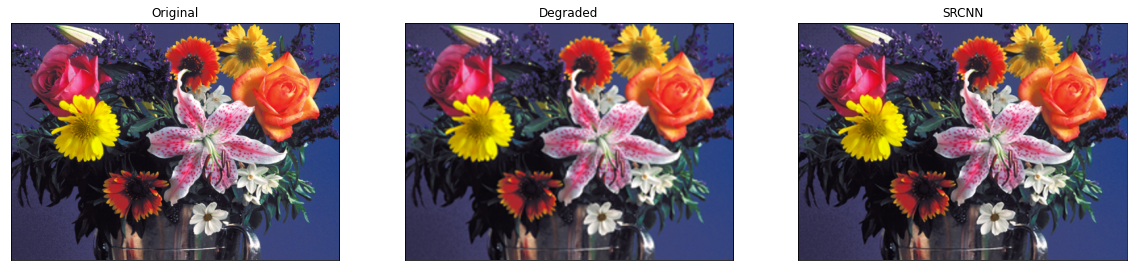

In [28]:
ref,degraded,output,scores=predict('source_x2/flowers_bicubic_x2.bmp', 'degraded_images_x2/', Model)
# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))#1 row,3 columns
axs[0].imshow(ref)#first subplot
#imshow assumes RGB images but cv2 loads images as BGR else channel mixing will take place and we will get weird images
axs[0].set_title('Original')
axs[1].imshow(degraded)#2nd subplot
axs[1].set_title('Degraded')
axs[2].imshow(output)
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])#leave them blank to remove ticks
    ax.set_yticks([])

In [0]:
def results(img_path, deg_path, model):
  for file in os.listdir(img_path):
      
      # perform super-resolution
      ref, degraded, output, scores = predict(img_path + file, deg_path, model)
      
      # display images as subplots
      fig, axs = plt.subplots(1, 3, figsize=(20, 8))
      axs[0].imshow(ref)
      axs[0].set_title('Original')
      axs[1].imshow(degraded)
      axs[1].set_title('Degraded')
      axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
      axs[2].imshow(output)
      axs[2].set_title('SRCNN')
      axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

      # remove the x and y ticks
      for ax in axs:
          ax.set_xticks([])
          ax.set_yticks([])

In [30]:
results('source_x2/','degraded_images_x2/', Model)

Output hidden; open in https://colab.research.google.com to view.

In [31]:
Model_3 = SRCNN(num_fil_1, ker_1, num_fil_2, ker_2, ker_3).to(device)
Model_3.load_state_dict(torch.load('/content/drive/My Drive/Final_Project/good/saved_weights_91_x3.pt'))

<All keys matched successfully>

In [32]:
results('source_x3/','degraded_images_x3/', Model_3)

Output hidden; open in https://colab.research.google.com to view.